In [9]:
import numpy as np
from keras.models import load_model, Model, clone_model
from keras.layers import Input, Average, Resizing

VGG16 = load_model('VGG16.keras')
MobileNetV2 = load_model('MobileNetV2.keras')
InceptionV3 = load_model('InceptionV3.keras')

VGG16_cloned = clone_model(VGG16)
VGG16_cloned.set_weights(VGG16.get_weights())
VGG16_cloned._name = 'VGG16_clone'

MobileNetV2_cloned = clone_model(MobileNetV2)
MobileNetV2_cloned.set_weights(MobileNetV2.get_weights())
MobileNetV2_cloned._name = 'MobileNetV2_clone'

InceptionV3_cloned = clone_model(InceptionV3)
InceptionV3_cloned.set_weights(InceptionV3.get_weights())
InceptionV3_cloned._name = 'InceptionV3_clone'

input_shape = (256, 256, 3)

input_layer = Input(shape=input_shape)

resized_input = Resizing(224, 224)(input_layer)

output1 = VGG16_cloned(input_layer)
output2 = MobileNetV2_cloned(resized_input)
output3 = InceptionV3_cloned(input_layer)

average_output = Average()([output1, output2, output3])

model = Model(inputs=input_layer, outputs=average_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# model.save('ensemble_model.keras')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 resizing (Resizing)         (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 VGG16_clone (Sequential)    (None, 1)                    2310380   ['input_1[0][0]']             
                                                          9                                       
                                                                                                  
 MobileNetV2_clone (Sequent  (None, 1)                    1831481   ['resizing[0][0]']        

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_path = "/mnt/c/LungCancerCT/final_test_images"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 99 images belonging to 2 classes.
4/4 [==============================] - 1s 225ms/step - loss: 1.3825 - accuracy: 1.0000
test acc: 1.0


Found 99 images belonging to 2 classes.
99/99 [==============================] - 4s 43ms/step


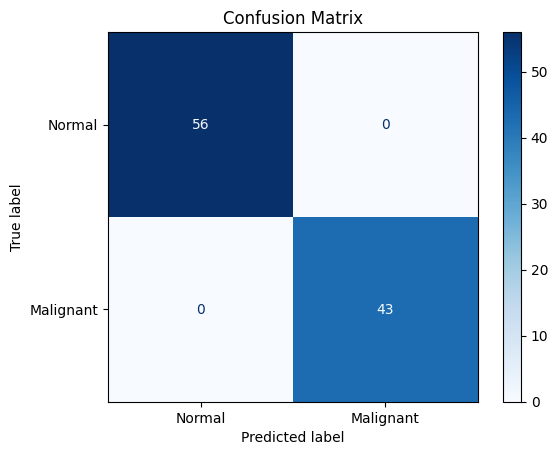

True Negatives (TN): 56 (56.57%)
False Positives (FP): 0 (0.00%)
False Negatives (FN): 0 (0.00%)
True Positives (TP): 43 (43.43%)


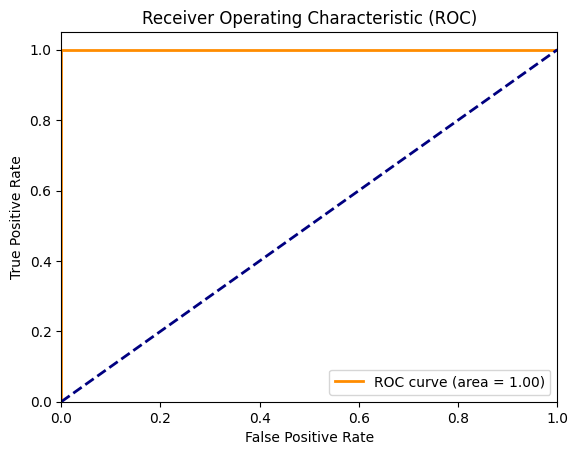

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
test_path = "/mnt/c/LungCancerCT/final_test_images"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size=1,
    class_mode='binary',
    shuffle=False)

predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()

true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

tn_percent = (tn / total) * 100
fp_percent = (fp / total) * 100
fn_percent = (fn / total) * 100
tp_percent = (tp / total) * 100

print(f"True Negatives (TN): {tn} ({tn_percent:.2f}%)")
print(f"False Positives (FP): {fp} ({fp_percent:.2f}%)")
print(f"False Negatives (FN): {fn} ({fn_percent:.2f}%)")
print(f"True Positives (TP): {tp} ({tp_percent:.2f}%)")

fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
